# **RestNet with Tensorflow Module**

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tensorflow as tf
import tensorflow.keras.optimizers.schedules as schedules
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# **Data Preparation**

In [2]:

def prepare_data(csv_path='./Data/TrainingSet/lables.csv'):
    labels = pd.read_csv(csv_path)
    labels['boneage_years'] = labels['boneage'] / 12.0
    mean_age = labels['boneage_years'].mean()
    std_age = labels['boneage_years'].std()
    labels['boneage_normalized'] = (labels['boneage_years'] - mean_age) / std_age
    labels['age_bin'] = pd.cut(labels['boneage'], bins=np.arange(0, 241, 12), labels=False)
    valid_bins = labels['age_bin'].value_counts()
    valid_bins = valid_bins[valid_bins >= 2].index
    labels = labels[labels['age_bin'].isin(valid_bins)]
    labels['image_id'] = labels['id'].astype(str) + '.png'
    return labels, mean_age, std_age


# **Display Images**

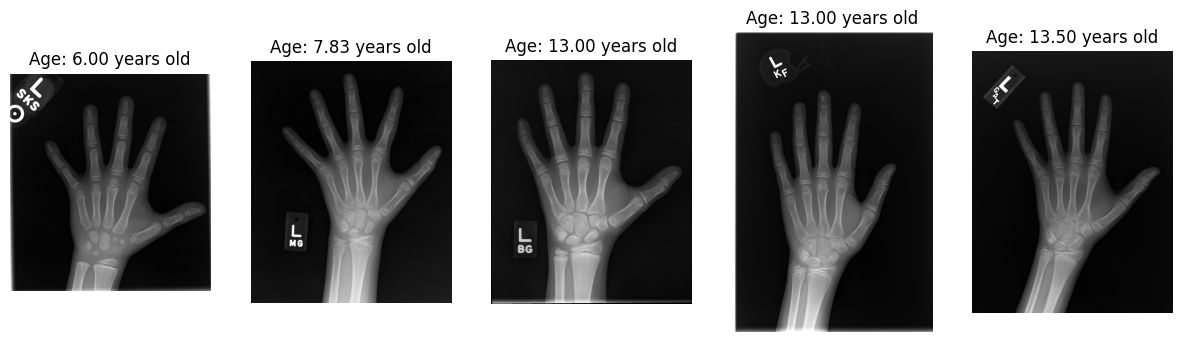

In [3]:
# Function to show sample images
def show_sample_images(labels, image_dir, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    sample_images = labels.sample(num_samples)  # Randomly select images
    for i, (idx, row) in enumerate(sample_images.iterrows()):
        image_path = os.path.join(image_dir, row['image_id'])
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[i].imshow(img, cmap='gray')  # Assuming grayscale images
            axes[i].set_title(f"Age: {row['boneage']/12:.2f} years old")
            axes[i].axis('off')
        else:
            print(f"Image not found: {image_path}")
            
labels, mean_age, std_age = prepare_data()
           
show_sample_images(labels, './Data/TrainingSet/Images/', num_samples=5)


# **Model Creation**

In [4]:
def create_model():
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze all layers except batch normalization layers
    for layer in base_model.layers:
        if isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    predictions = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# **Model Preparation**

In [5]:
def dataframe_to_dataset(dataframe, directory, batch_size=16, target_size=(224, 224), training=True):
    def load_and_preprocess(image_id, label, training=True):
        image_path = tf.strings.join(["./Data/TrainingSet/Images", image_id], separator="/")
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, (224, 224)) / 255.0  # Normalize

        # Data Augmentation (only if training)
        if training:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.2)
            image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
            image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
            image = tf.image.random_hue(image, max_delta=0.1)

        return image, label
    
    dataset = tf.data.Dataset.from_tensor_slices((dataframe['image_id'].values, dataframe['boneage_normalized'].values))
    dataset = dataset.map(lambda x, y: load_and_preprocess(x, y, training), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(len(dataframe)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


class MetricsCallback(Callback):
    def __init__(self, validation_data, mean_age, std_age):
        super().__init__()
        self.validation_data = validation_data
        self.mean_age = mean_age
        self.std_age = std_age

    def on_epoch_end(self, epoch, logs=None):
        true_ages = []
        predicted_ages = []
        
        for images, labels in self.validation_data:
            predictions = self.model.predict_on_batch(images)  # ✅ Using batch-specific method                 
            # De-normalizing
            true_ages.extend((labels.numpy() * self.std_age) + self.mean_age)
            predicted_ages.extend((predictions.flatten() * self.std_age) + self.mean_age)

        # Compute evaluation metrics
        mae = mean_absolute_error(true_ages, predicted_ages)
        rmse = np.sqrt(mean_squared_error(true_ages, predicted_ages))
        r2 = r2_score(true_ages, predicted_ages)

        # Print results for this epoch
        print(f"\n📌 Epoch {epoch + 1} Metrics:")
        print(f"📏 MAE: {mae:.2f} years | 📊 RMSE: {rmse:.2f} years | 📈 R²: {r2:.4f}\n")


def create_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        if isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='linear')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# **Train Model**

In [6]:
def train_model(model, train_dataset, val_dataset, mean_age, std_age, epochs=20):
    np.save('normalization_params_ResNet.npy', {'mean': mean_age, 'std': std_age})
    metrics_callback = MetricsCallback(val_dataset, mean_age, std_age)
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        ModelCheckpoint('best_ResNet_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        metrics_callback  
    ]
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return history

# **Plot Training**

In [7]:


def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.tight_layout()
    plt.show()


# **Main Execution**

### *First Training*

Creating model...
Training model...
Epoch 1/20
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - loss: 2.8859 - mae: 1.3043
Epoch 1: val_loss improved from inf to 2.49645, saving model to best_ResNet_model.keras

📌 Epoch 1 Metrics:
📏 MAE: 4.38 years | 📊 RMSE: 5.19 years | 📈 R²: -1.3010

631/631 ━━━━━━━━━━━━━━━━━━━━ 444s 670ms/step - loss: 2.8853 - mae: 1.3041 - val_loss: 2.4965 - val_mae: 1.2758 - learning_rate: 1.0000e-04
Epoch 2/20
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - loss: 1.8470 - mae: 1.0204
Epoch 2: val_loss improved from 2.49645 to 1.11945, saving model to best_ResNet_model.keras

📌 Epoch 2 Metrics:
📏 MAE: 2.62 years | 📊 RMSE: 3.28 years | 📈 R²: 0.0831

631/631 ━━━━━━━━━━━━━━━━━━━━ 427s 659ms/step - loss: 1.8469 - mae: 1.0203 - val_loss: 1.1194 - val_mae: 0.7623 - learning_rate: 1.0000e-04
Epoch 3/20
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - loss: 1.6722 - mae: 0.9611
Epoch 3: val_loss improved from 1.11945 to 0.67542, saving model to best_ResNet_model.keras

📌 Epoch 3 Met

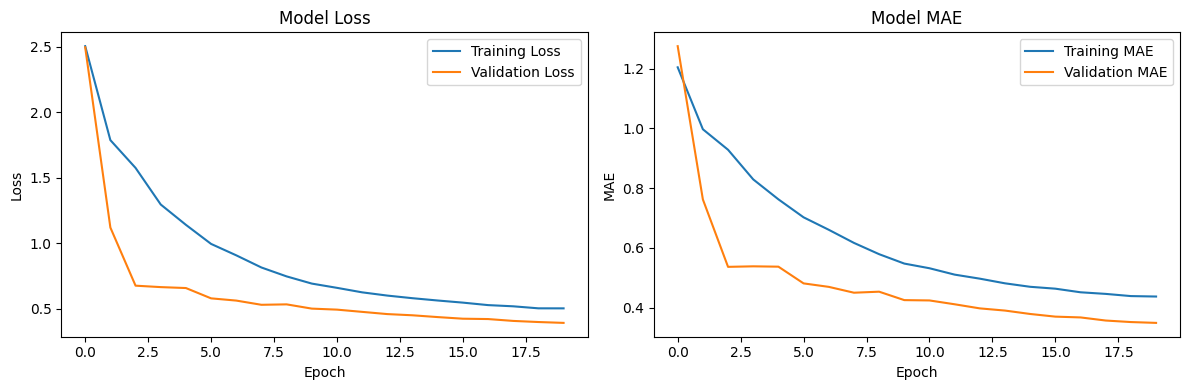

In [ ]:

if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=UserWarning, module='keras')
    labels, mean_age, std_age = prepare_data()
    train_labels, val_labels = train_test_split(
        labels, test_size=0.2, stratify=labels['age_bin'], random_state=42)
    train_dataset = dataframe_to_dataset(train_labels, './Data/TrainingSet/Images/', batch_size=16, training=True)
    val_dataset = dataframe_to_dataset(val_labels, './Data/TrainingSet/Images/', batch_size=32, training=False)
    print("Creating model...")
    model = create_model()
    print("Training model...")
    history = train_model(model, train_dataset, val_dataset, mean_age, std_age, epochs=20)
    plot_training_history(history)


#### *Second Training with validation set and training set + upgrades*

Epoch 1/35
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - loss: 0.5546 - mae: 0.5981
Epoch 1: val_mae improved from inf to 0.35399, saving model to modelVal.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 575s 690ms/step - loss: 0.5544 - mae: 0.5980 - val_loss: 0.2031 - val_mae: 0.3540 - learning_rate: 9.8472e-05
Epoch 2/35
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - loss: 0.2803 - mae: 0.4173
Epoch 2: val_mae improved from 0.35399 to 0.33967, saving model to modelVal.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 605s 750ms/step - loss: 0.2803 - mae: 0.4173 - val_loss: 0.1930 - val_mae: 0.3397 - learning_rate: 9.3981e-05
Epoch 3/35
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - loss: 0.2584 - mae: 0.4026
Epoch 3: val_mae improved from 0.33967 to 0.33615, saving model to modelVal.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 616s 762ms/step - loss: 0.2584 - mae: 0.4026 - val_loss: 0.1824 - val_mae: 0.3361 - learning_rate: 8.6801e-05
Epoch 4/35
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - loss: 0.2476 - mae: 0.3946
Epoch 4: 

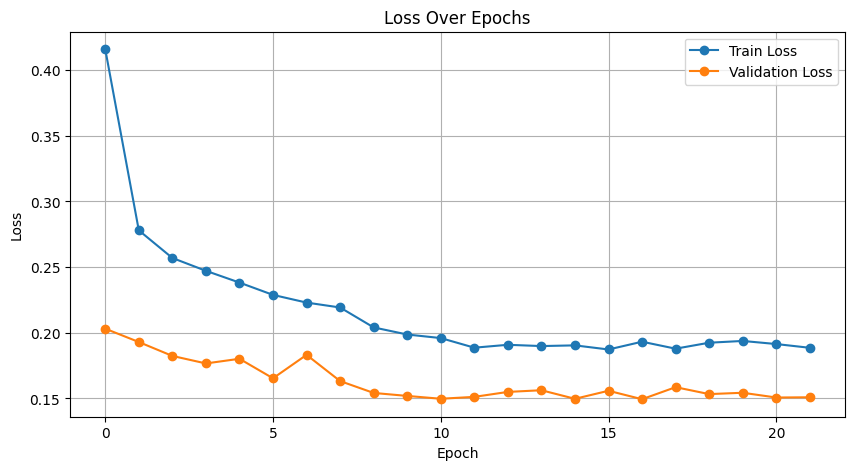

In [ ]:

# Load the existing model
model_val = load_model('best_ResNet_model.keras')

# Load normalization parameters
norm_params = np.load('normalization_params_ResNet.npy', allow_pickle=True).item()
mean_age, std_age = norm_params['mean'], norm_params['std']

# Load the data
train_labels = pd.read_csv('./Data/TrainingSet/lables.csv')
train_labels['boneage_years'] = train_labels['boneage'] / 12.0  
val_labels = pd.read_csv('./Data/ValidationSet/lables.csv')
val_labels['boneage_years'] = val_labels['Bone Age (months)'] / 12.0  
val_labels['id'] = val_labels['Image ID'].astype(str) 

# Update the data with normalization
for labels in [train_labels, val_labels]:
    labels['boneage_normalized'] = (labels['boneage_years'] - mean_age) / std_age
    labels['image_id'] = labels['id'].astype(str) + '.png'

# Function to prepare the dataset
def dataframe_to_dataset(dataframe, directory, batch_size=16, target_size=(224, 224), shuffle=True):
    def load_and_preprocess(image_id, label):
        image_path = tf.strings.join([directory, image_id], separator="/")
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, target_size) / 255.0
        
        # Extended Augmentation
        if tf.random.uniform(()) > 0.5:
            image = tf.image.random_flip_left_right(image)   # Horizontal flip
            image = tf.image.random_brightness(image, max_delta=0.2) # Adjust brightness
            image = tf.image.random_contrast(image, 0.7, 1.3)  # Adjust contrast
            image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Rotation
            image = tf.image.random_saturation(image, 0.7, 1.3)  # Adjust color saturation
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((dataframe['image_id'].values, dataframe['boneage_normalized'].values))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(len(dataframe))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Prepare Train and Validation Sets
train_dataset = dataframe_to_dataset(train_labels, './Data/TrainingSet/Images/', batch_size=16)
val_dataset = dataframe_to_dataset(val_labels, './Data/ValidationSet/Images/', batch_size=32, shuffle=False)

# Enable fine-tuning for some layers
for layer in model_val.layers:
    if "conv5" in layer.name or isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True  # Unlock deeper layers for training
    else:
        layer.trainable = False  # Keep lower layers frozen

# ✅ Add an additional Dense layer with Dropout
x = model_val.output
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)  # Reduced to 0.2
output = Dense(1, activation='linear')(x)
model_val = Model(inputs=model_val.input, outputs=output)

# Define Cosine Decay Scheduler
lr_schedule = schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    alpha=1e-6
)

# Recompile the model
model_val.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse', metrics=['mae'])

# Callbacks to prevent overfitting
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1),  # שינינו patience ל-3
    ModelCheckpoint('modelVal.keras', monitor='val_mae', save_best_only=True, verbose=1),  # שמירה לפי val_mae
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)  # הגדלנו ל-5
]

# Continue training the existing model
history = model_val.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=35,
    callbacks=callbacks,
    verbose=1
)

# Save the improved model
model_val.save('ResNet_modelVal.keras')

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv("training_history.csv", index=False)

# 📊 Plot performance graph
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.grid()
plt.show()


## **The Test!**

In [ ]:


# Load normalization parameters
normalization_params = np.load('normalization_params_ResNet.npy', allow_pickle=True).item()
mean_age = normalization_params['mean']
std_age = normalization_params['std']

# Load best trained model
model = load_model('modelVal.keras')

# Load test data

warnings.filterwarnings("ignore", category=UserWarning, module='keras')
def load_test_data(csv_path='./Data/TestSet/lables.csv', image_path='./Data/TestSet/Images/'):
    test_labels = pd.read_csv(csv_path)
    
    # Normalize bone age
    test_labels['BoneAge'] = test_labels['Ground truth bone age (months)'] / 12.0
    test_labels['boneage_normalized'] = (test_labels['BoneAge'] - mean_age) / std_age

    # Prepare image filenames
    test_labels['id'] = test_labels['Case ID'].astype(str) + '.png'

    # Data generator for test images
    test_datagen = ImageDataGenerator(rescale=1.0/255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_labels,
        directory=image_path,
        x_col='id',
        y_col='boneage_normalized',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False
    )
    
    return test_generator, test_labels

# Load test data
test_generator, test_labels = load_test_data()

# Make predictions
predictions = model.predict(test_generator)

# Denormalize predictions
predicted_bone_ages = (predictions * std_age) + mean_age
true_bone_ages = (test_labels['boneage_normalized'] * std_age) + mean_age

# Compute evaluation metrics
mae = mean_absolute_error(true_bone_ages, predicted_bone_ages)
rmse = np.sqrt(mean_squared_error(true_bone_ages, predicted_bone_ages))
r2 = r2_score(true_bone_ages, predicted_bone_ages)

# Print evaluation results
print("\n🔍 Model Evaluation Metrics:")
print(f"📏 Mean Absolute Error (MAE): {mae:.2f} years")
print(f"📊 Root Mean Squared Error (RMSE): {rmse:.2f} years")
print(f"📈 R² Score: {r2:.4f}")



Found 200 validated image filenames.
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 551ms/step

🔍 Model Evaluation Metrics:
📏 Mean Absolute Error (MAE): 1.03 years
📊 Root Mean Squared Error (RMSE): 1.29 years
📈 R² Score: 0.8697


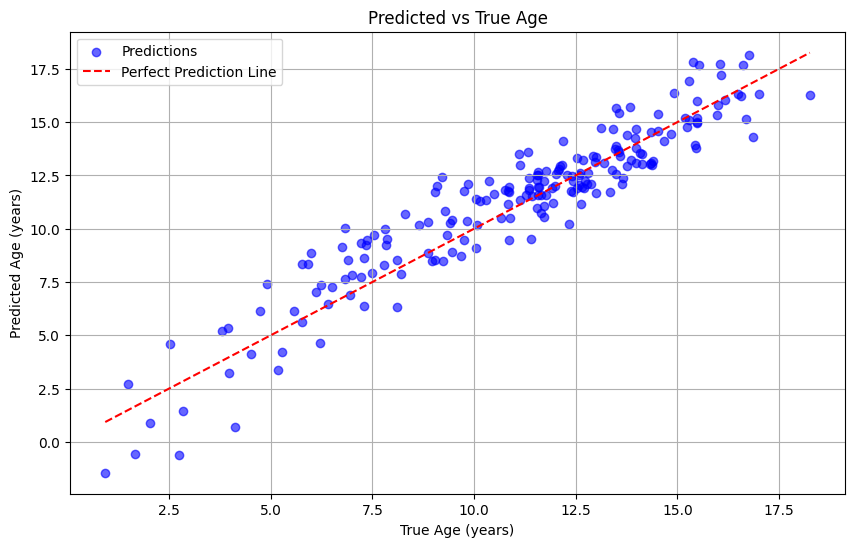

In [10]:

# Create a DataFrame to display predictions alongside true values
results_df = pd.DataFrame({
    "Filename": test_labels['id'].values,
    "True Age (years)": true_bone_ages.to_numpy().flatten(),
    "Predicted Age (years)": predicted_bone_ages.flatten()
})

# ------------------- Visualization ------------------- #
plt.figure(figsize=(10, 6))
plt.scatter(true_bone_ages, predicted_bone_ages, alpha=0.6, color='blue', label="Predictions")
plt.plot([min(true_bone_ages), max(true_bone_ages)], [min(true_bone_ages), max(true_bone_ages)], 'r--', label="Perfect Prediction Line")
plt.xlabel("True Age (years)")
plt.ylabel("Predicted Age (years)")
plt.title("Predicted vs True Age")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# if you dont want to run all the trains just use this: 

# Load the data
train_labels = pd.read_csv('./Data/TrainingSet/lables.csv')
train_labels['boneage_years'] = train_labels['boneage'] / 12.0  # בדקי שם עמודה מתאים
val_labels = pd.read_csv('./Data/ValidationSet/lables.csv')
val_labels['boneage_years'] = val_labels['Bone Age (months)'] / 12.0  # בדקי שם עמודה מתאים
val_labels['id'] = val_labels['Image ID'].astype(str) 

# Update the data with normalization
for labels in [train_labels, val_labels]:
    labels['boneage_normalized'] = (labels['boneage_years'] - mean_age) / std_age
    labels['image_id'] = labels['id'].astype(str) + '.png'


## **Show predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


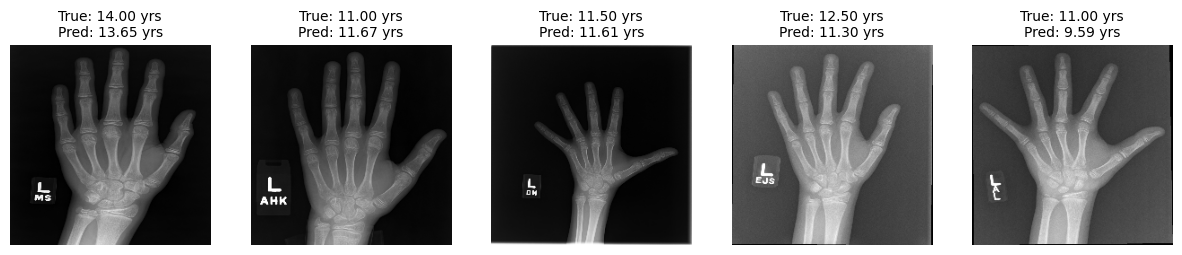

In [110]:
from tensorflow.keras.models import load_model
model_val = load_model('ResNet_modelVal.keras')

# פונקציה להצגת מספר תמונות עם גיל אמיתי ופרדיקציה
def show_multiple_predictions(sample_rows):
    fig, axes = plt.subplots(1, len(sample_rows), figsize=(15, 5))
    
    for i, (_, row) in enumerate(sample_rows.iterrows()):
        image_path = f"./Data/ValidationSet/Images/{row['image_id']}"
        true_age = row['boneage_years']

        # טוענים את התמונה
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, (224, 224)) / 255.0
        image = tf.expand_dims(image, axis=0)  # הוספת ממד אצווה

        # ביצוע חיזוי
        predicted_age = model_val.predict(image)[0][0]
        predicted_age = (predicted_age * std_age) + mean_age  # ביטול הנורמליזציה

        # הצגת התמונה
        axes[i].imshow(image[0])
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_age:.2f} yrs\nPred: {predicted_age:.2f} yrs", fontsize=10)

    plt.show()

# בוחרים כמה תמונות אקראיות ומציגים
sample_rows = val_labels.sample(5)  # בחר 5 תמונות אקראיות
show_multiple_predictions(sample_rows)


# **EfficientNet Moudle**

In [19]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
import tensorflow as tf

# Create EfficientNetB3 Model
def create_efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze all layers except BatchNormalization layers
    for layer in base_model.layers:
        if isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    predictions = Dense(1, dtype='float32', activation='linear')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Load Normalization Parameters
norm_params = np.load('normalization_params_ResNet.npy', allow_pickle=True).item()
mean_age, std_age = norm_params['mean'], norm_params['std']


train_labels['image_path'] = './Data/TrainingSet/Images/' + train_labels['image_id']
val_labels['image_path'] = './Data/ValidationSet/Images/' + val_labels['image_id']

# Prepare Data Loaders
def dataframe_to_dataset(dataframe, batch_size=16, training=True):
    def load_and_preprocess(image_path, label, training=True):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, (224, 224)) / 255.0  # נורמליזציה
        
        # Data Augmentation (רק אם זה אימון)
        if training:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.2)
            image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
            image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
            image = tf.image.random_hue(image, max_delta=0.1)
        
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((dataframe['image_path'].values, dataframe['boneage_normalized'].values))
    dataset = dataset.map(lambda x, y: load_and_preprocess(x, y, training), num_parallel_calls=tf.data.AUTOTUNE)
    
    # שיפור הביצועים
    dataset = dataset.cache()  # אחסון בזיכרון אם אפשר
    dataset = dataset.shuffle(1000) if training else dataset  # Shuffle רק ב-Training
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)  # טעינה מקבילה

    return dataset

train_dataset = dataframe_to_dataset(train_labels, batch_size=8, training=True)
val_dataset = dataframe_to_dataset(val_labels, batch_size=16, training=False)

# Train Model
model = create_efficientnet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_EfficientNet_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=callbacks,
    verbose=1
)

# Save Model
model.save('EfficientNet_model.keras')


Epoch 1/25
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 3.0343 - mae: 1.3403
Epoch 1: val_loss improved from inf to 0.96962, saving model to best_EfficientNet_model.keras
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 283s 172ms/step - loss: 3.0339 - mae: 1.3402 - val_loss: 0.9696 - val_mae: 0.7070 - learning_rate: 1.0000e-04
Epoch 2/25
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 1.9694 - mae: 1.0575
Epoch 2: val_loss improved from 0.96962 to 0.90633, saving model to best_EfficientNet_model.keras
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 260s 165ms/step - loss: 1.9692 - mae: 1.0575 - val_loss: 0.9063 - val_mae: 0.6673 - learning_rate: 1.0000e-04
Epoch 3/25
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 1.5873 - mae: 0.9485
Epoch 3: val_loss improved from 0.90633 to 0.81762, saving model to best_EfficientNet_model.keras
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 260s 165ms/step - loss: 1.5871 - mae: 0.9484 - val_loss: 0.8176 - val_mae: 0.6223 - learning_rate: 1.0000e-04
Epoch 4/25
1577/1577 ━━━━━━━━━━━

In [31]:
from tensorflow.keras.models import load_model
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# טוענים את המודל השמור
model = load_model('best_EfficientNet_model.keras')

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_EfficientNet_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]
# ממשיכים לאמן עם יותר אפוקים
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # מספר אפוקים נוספים
    callbacks=callbacks,
    verbose=1
)

# שומרים את המודל המעודכן
model.save('EfficientNet_model_continued.keras')
# שמירת ההיסטוריה לקובץ CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('EfficientNet_model_continued.csv', index=False)
print("History saved to EfficientNet_model_continued.csv")



Epoch 1/10
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.5414 - mae: 0.5002
Epoch 1: val_loss improved from inf to 0.39355, saving model to best_EfficientNet_model.keras
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 312s 192ms/step - loss: 0.5413 - mae: 0.5002 - val_loss: 0.3935 - val_mae: 0.3991 - learning_rate: 1.0000e-04
Epoch 2/10
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.5186 - mae: 0.4890
Epoch 2: val_loss improved from 0.39355 to 0.37610, saving model to best_EfficientNet_model.keras
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 297s 188ms/step - loss: 0.5185 - mae: 0.4890 - val_loss: 0.3761 - val_mae: 0.3880 - learning_rate: 1.0000e-04
Epoch 3/10
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.5214 - mae: 0.4945
Epoch 3: val_loss did not improve from 0.37610
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 287s 182ms/step - loss: 0.5213 - mae: 0.4945 - val_loss: 0.3821 - val_mae: 0.3975 - learning_rate: 1.0000e-04
Epoch 4/10
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.5244 - mae: 0.496

## **Test**

In [116]:
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

# Load normalization parameters
normalization_params = np.load('normalization_params_ResNet.npy', allow_pickle=True).item()
mean_age = normalization_params['mean']
std_age = normalization_params['std']
# Denormalize predictions
predicted_bone_ages = (predictions * std_age) + mean_age
true_bone_ages = (test_labels['boneage_normalized'] * std_age) + mean_age
# Load best trained model
model = load_model('best_EfficientNet_model.keras')
warnings.filterwarnings("ignore", category=UserWarning, module='keras')
def load_test_data(csv_path='./Data/TestSet/lables.csv', image_path='./Data/TestSet/Images/'):
    test_labels = pd.read_csv(csv_path)
    
    # Normalize bone age
    test_labels['BoneAge'] = test_labels['Ground truth bone age (months)'] / 12.0
    test_labels['boneage_normalized'] = (test_labels['BoneAge'] - mean_age) / std_age

    # Prepare image filenames
    test_labels['id'] = test_labels['Case ID'].astype(str) + '.png'

    # Data generator for test images
    test_datagen = ImageDataGenerator(rescale=1.0/255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_labels,
        directory=image_path,
        x_col='id',
        y_col='boneage_normalized',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False
    )
    
    return test_generator, test_labels

# Load test data
test_generator, test_labels = load_test_data()

# Make predictions
predictions = model.predict(test_generator)

# Denormalize predictions
predicted_bone_ages = (predictions * std_age) + mean_age
true_bone_ages = (test_labels['boneage_normalized'] * std_age) + mean_age

# Compute evaluation metrics
mae = mean_absolute_error(true_bone_ages, predicted_bone_ages)
rmse = np.sqrt(mean_squared_error(true_bone_ages, predicted_bone_ages))
r2 = r2_score(true_bone_ages, predicted_bone_ages)

# Print evaluation results
print("\n🔍 Model Evaluation Metrics:")
print(f"📏 Mean Absolute Error (MAE): {mae:.2f} years")
print(f"📊 Root Mean Squared Error (RMSE): {rmse:.2f} years")
print(f"📈 R² Score: {r2:.4f}")



Found 200 validated image filenames.
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step

🔍 Model Evaluation Metrics:
📏 Mean Absolute Error (MAE): 1.37 years
📊 Root Mean Squared Error (RMSE): 1.73 years
📈 R² Score: 0.7297


: 

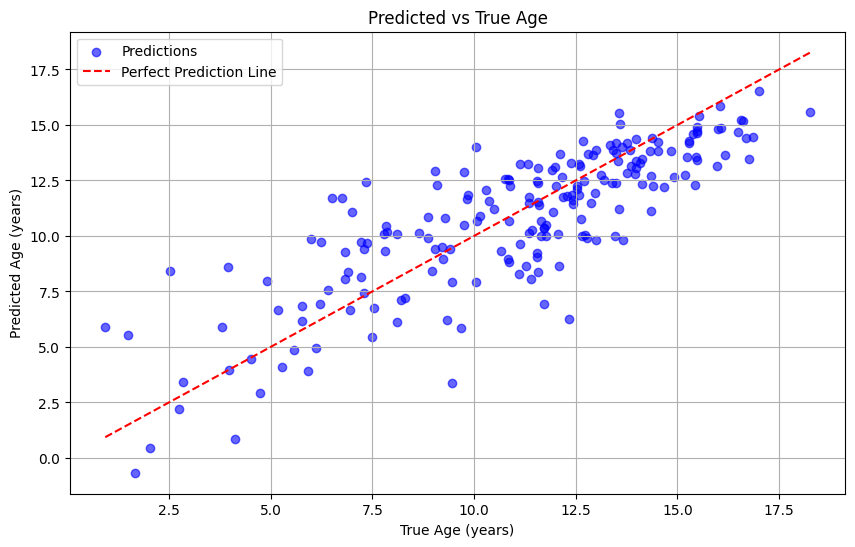

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(true_bone_ages, predicted_bone_ages, alpha=0.6, color='blue', label="Predictions")
plt.plot([min(true_bone_ages), max(true_bone_ages)], [min(true_bone_ages), max(true_bone_ages)], 'r--', label="Perfect Prediction Line")
plt.xlabel("True Age (years)")
plt.ylabel("Predicted Age (years)")
plt.title("Predicted vs True Age")
plt.legend()
plt.grid(True)
plt.show()

## **Show predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


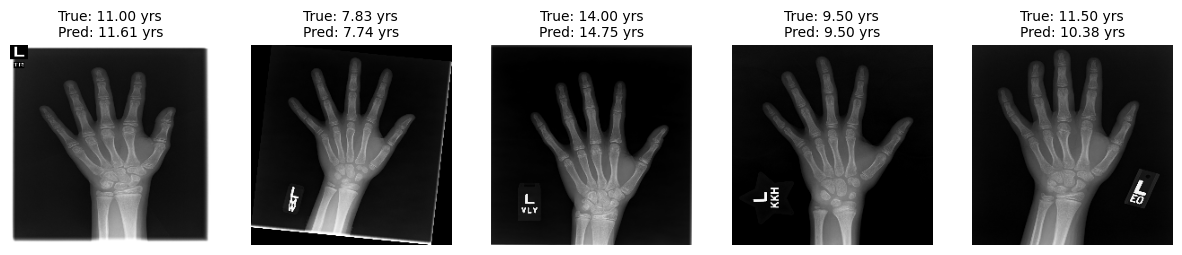

In [93]:
from tensorflow.keras.models import load_model
model_val = load_model('best_EfficientNet_model.keras')

# פונקציה להצגת מספר תמונות עם גיל אמיתי ופרדיקציה
def show_multiple_predictions(sample_rows):
    fig, axes = plt.subplots(1, len(sample_rows), figsize=(15, 5))
    
    for i, (_, row) in enumerate(sample_rows.iterrows()):
        image_path = f"./Data/ValidationSet/Images/{row['image_id']}"
        true_age = row['boneage_years']

        # טוענים את התמונה
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, (224, 224)) / 255.0
        image = tf.expand_dims(image, axis=0)  # הוספת ממד אצווה

        # ביצוע חיזוי
        predicted_age = model_val.predict(image)[0][0]
        predicted_age = (predicted_age * std_age) + mean_age  # ביטול הנורמליזציה

        # הצגת התמונה
        axes[i].imshow(image[0])
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_age:.2f} yrs\nPred: {predicted_age:.2f} yrs", fontsize=10)

    plt.show()

# בוחרים כמה תמונות אקראיות ומציגים
sample_rows = val_labels.sample(5)  # בחר 10 תמונות אקראיות
show_multiple_predictions(sample_rows)


# **CNN Module**

## *Dataset Class*

In [43]:
class BoneAgeDataset(Dataset):
    def __init__(self, csv_path, image_folder, transform=None):
        self.data = pd.read_csv(csv_path)
        
        # Compute mean & std for normalization
        self.data['boneage_years'] = self.data['boneage'] / 12.0
        self.mean_age = self.data['boneage_years'].mean()
        self.std_age = self.data['boneage_years'].std()
        self.data['boneage_normalized'] = (self.data['boneage_years'] - self.mean_age) / self.std_age

        # Add image paths
        self.data['image_id'] = self.data['id'].astype(str) + '.png'
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.data.iloc[idx]['image_id'])
        
        # Read grayscale image
        image = Image.open(img_path).convert('L')  
        image = image.resize((224, 224))  

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.data.iloc[idx]['boneage_normalized'], dtype=torch.float32)
        return image, label


### *2. Data Loader Function*

In [44]:
def create_dataloaders(csv_path, image_folder, batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    dataset = BoneAgeDataset(csv_path, image_folder, transform)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, dataset.mean_age, dataset.std_age

### *3. CNN Model Definition*

In [56]:
class BoneAgeCNN(nn.Module):
    def __init__(self):
        super(BoneAgeCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  
        x = self.fc_layers(x)
        return x

### *4. Training Function*

In [46]:
def train_model(model, train_loader, val_loader, mean_age, std_age, epochs=15, lr=5e-5, patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # יצירת ה-scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    best_val_loss = float('inf')  # שמירת ה-loss הטוב ביותר
    patience_counter = 0  # סופר כמה אפוקים ללא שיפור

    for epoch in range(epochs):
        # ---- Training Loop ----
        model.train()
        train_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            images, labels = images.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # ---- Validation Loop ----
        model.eval()
        val_loss = 0
        predictions, true_values = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).unsqueeze(1)
                outputs = model(images)

                val_loss += criterion(outputs, labels).item()
                predictions.extend(outputs.cpu().numpy().flatten())
                true_values.extend(labels.cpu().numpy().flatten())

        val_loss /= len(val_loader)

        # Denormalize predictions
        predictions = (np.array(predictions) * std_age) + mean_age
        true_values = (np.array(true_values) * std_age) + mean_age

        # Compute evaluation metrics
        mae = mean_absolute_error(true_values, predictions)

        # Print Epoch Summary
        print(f"\n📢 Epoch {epoch+1}/{epochs} Results:")
        print(f"📉 Train Loss: {train_loss:.4f} | 📊 Val Loss: {val_loss:.4f} | 📏 MAE: {mae:.2f} years")

        # Save model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "CNN_Model.pth")
            np.save("CNN_Normalization_Params.npy", np.array([mean_age, std_age]))
            print("✅ Model saved! (Best so far)")
            patience_counter = 0  # Reset the patience counter
        else:
            patience_counter += 1  # אין שיפור, להגדיל את הספירה
            print(f"⏳ No improvement for {patience_counter}/{patience} epochs")

        # Stop training if patience is exceeded
        if patience_counter >= patience:
            print("\n🚀 Early Stopping Activated! Stopping training...")
            break  # יוצא מהלולאת אימון

        # עדכון קצב הלמידה
        scheduler.step(val_loss)

    print("\n✅ Training finished!")


### *5. Main Execution*

In [47]:

def main():
    train_loader, val_loader, mean_age, std_age = create_dataloaders("./Data/TrainingSet/lables.csv", "./Data/TrainingSet/Images/")
    
    model = BoneAgeCNN()
    train_model(model, train_loader, val_loader, mean_age, std_age)

if __name__ == "__main__":
    main()

c:\Users\galli\OneDrive\Desktop\Sce\ThirdYear\firstSemester\deepLearning\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/15 [Training]: 100%|██████████| 316/316 [08:04<00:00,  1.53s/it]



📢 Epoch 1/15 Results:
📉 Train Loss: 0.9763 | 📊 Val Loss: 0.6714 | 📏 MAE: 2.23 years
✅ Model saved! (Best so far)


Epoch 2/15 [Training]: 100%|██████████| 316/316 [07:48<00:00,  1.48s/it]



📢 Epoch 2/15 Results:
📉 Train Loss: 0.6593 | 📊 Val Loss: 0.5687 | 📏 MAE: 2.03 years
✅ Model saved! (Best so far)


Epoch 3/15 [Training]: 100%|██████████| 316/316 [07:50<00:00,  1.49s/it]



📢 Epoch 3/15 Results:
📉 Train Loss: 0.5345 | 📊 Val Loss: 0.4326 | 📏 MAE: 1.79 years
✅ Model saved! (Best so far)


Epoch 4/15 [Training]: 100%|██████████| 316/316 [07:49<00:00,  1.49s/it]



📢 Epoch 4/15 Results:
📉 Train Loss: 0.4480 | 📊 Val Loss: 0.4348 | 📏 MAE: 1.76 years
⏳ No improvement for 1/7 epochs


Epoch 5/15 [Training]: 100%|██████████| 316/316 [07:47<00:00,  1.48s/it]



📢 Epoch 5/15 Results:
📉 Train Loss: 0.3848 | 📊 Val Loss: 0.3721 | 📏 MAE: 1.64 years
✅ Model saved! (Best so far)


Epoch 6/15 [Training]: 100%|██████████| 316/316 [07:49<00:00,  1.48s/it]



📢 Epoch 6/15 Results:
📉 Train Loss: 0.3198 | 📊 Val Loss: 0.3650 | 📏 MAE: 1.66 years
✅ Model saved! (Best so far)


Epoch 7/15 [Training]: 100%|██████████| 316/316 [07:51<00:00,  1.49s/it]



📢 Epoch 7/15 Results:
📉 Train Loss: 0.2805 | 📊 Val Loss: 0.3631 | 📏 MAE: 1.61 years
✅ Model saved! (Best so far)


Epoch 8/15 [Training]: 100%|██████████| 316/316 [08:05<00:00,  1.54s/it]



📢 Epoch 8/15 Results:
📉 Train Loss: 0.2495 | 📊 Val Loss: 0.4761 | 📏 MAE: 1.86 years
⏳ No improvement for 1/7 epochs


Epoch 9/15 [Training]: 100%|██████████| 316/316 [07:39<00:00,  1.45s/it]



📢 Epoch 9/15 Results:
📉 Train Loss: 0.2297 | 📊 Val Loss: 0.3604 | 📏 MAE: 1.65 years
✅ Model saved! (Best so far)


Epoch 10/15 [Training]: 100%|██████████| 316/316 [07:38<00:00,  1.45s/it]



📢 Epoch 10/15 Results:
📉 Train Loss: 0.1987 | 📊 Val Loss: 0.3419 | 📏 MAE: 1.61 years
✅ Model saved! (Best so far)


Epoch 11/15 [Training]: 100%|██████████| 316/316 [07:39<00:00,  1.45s/it]



📢 Epoch 11/15 Results:
📉 Train Loss: 0.1813 | 📊 Val Loss: 0.3466 | 📏 MAE: 1.62 years
⏳ No improvement for 1/7 epochs


Epoch 12/15 [Training]: 100%|██████████| 316/316 [07:39<00:00,  1.45s/it]



📢 Epoch 12/15 Results:
📉 Train Loss: 0.1689 | 📊 Val Loss: 0.3811 | 📏 MAE: 1.70 years
⏳ No improvement for 2/7 epochs


Epoch 13/15 [Training]: 100%|██████████| 316/316 [07:39<00:00,  1.45s/it]



📢 Epoch 13/15 Results:
📉 Train Loss: 0.1551 | 📊 Val Loss: 0.3716 | 📏 MAE: 1.65 years
⏳ No improvement for 3/7 epochs


Epoch 14/15 [Training]: 100%|██████████| 316/316 [07:40<00:00,  1.46s/it]



📢 Epoch 14/15 Results:
📉 Train Loss: 0.1473 | 📊 Val Loss: 0.4117 | 📏 MAE: 1.80 years
⏳ No improvement for 4/7 epochs


Epoch 15/15 [Training]: 100%|██████████| 316/316 [07:39<00:00,  1.46s/it]



📢 Epoch 15/15 Results:
📉 Train Loss: 0.1160 | 📊 Val Loss: 0.3652 | 📏 MAE: 1.67 years
⏳ No improvement for 5/7 epochs

✅ Training finished!


### *Model Evaluation For TEST:*

C:\Users\galli\AppData\Local\Temp\ipykernel_7416\2117197751.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de


🔍 Model Evaluation Metrics:
📏 Mean Absolute Error (MAE): 1.07 years
📊 Root Mean Squared Error (RMSE): 1.32 years
📈 R² Score: 0.7746


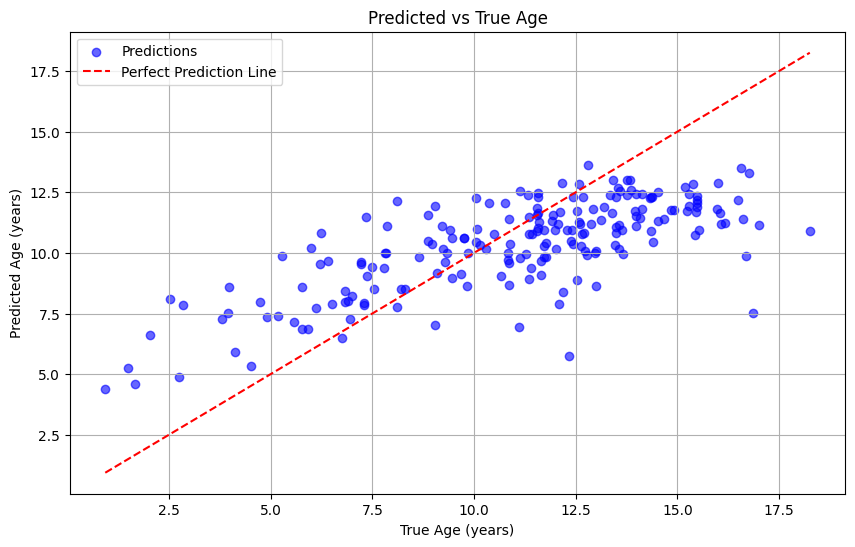

In [ ]:
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model_path, csv_path, image_folder, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # טעינת פרמטרי הנורמליזציה
    mean_age, std_age = np.load("CNN_Normalization_Params.npy")
    
    # טעינת המודל
    model = BoneAgeCNN()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # טעינת קובץ ה-CSV
    test_data = pd.read_csv(csv_path)
    test_data['image_id'] = test_data['Case ID'].astype(str) + '.png'
    
    # שמירת גיל העצם האמיתי
    test_data['boneage'] = test_data['Ground truth bone age (months)']/12.0
    
    # יצירת רשימת נתיבי תמונות ותוויות
    image_paths = [os.path.join(image_folder, img) for img in test_data['image_id']]
    true_ages = test_data['boneage'].values  # גיל העצם האמיתי

    # הגדרת הטרנספורמציות
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # טעינת התמונות כטנזור
    images = []
    for path in image_paths:
        image = Image.open(path)
        image = transform(image)
        images.append(image)

    # המרת הרשימות לטנזורים
    images = torch.stack(images)
    true_ages = torch.tensor(true_ages, dtype=torch.float32)

    # יצירת DataLoader
    test_dataset = TensorDataset(images, true_ages)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # ביצוע תחזיות
    predictions, ground_truths = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images).cpu().numpy().flatten()
            
            # החזרת התחזיות לטווח המקורי
            outputs = (outputs * std_age) + mean_age

            predictions.extend(outputs)
            ground_truths.extend(labels.numpy().flatten())

    # המרת המדדים לשנים (12 חודשים = 1 שנה)
    true_ages_years = np.array(ground_truths) 
    predicted_ages_years = np.array(predictions) 

    # חישוב מדדים
    mae = mean_absolute_error(true_ages_years, predicted_ages_years)
    rmse = np.sqrt(mean_squared_error(true_ages_years, predicted_ages_years))
    r2 = r2_score(true_ages_years, predicted_ages_years)

    # הדפסת המדדים
    print("\n🔍 Model Evaluation Metrics:")
    print(f"📏 Mean Absolute Error (MAE): {mae:.2f} years")
    print(f"📊 Root Mean Squared Error (RMSE): {rmse:.2f} years")
    print(f"📈 R² Score: {r2:.4f}")

    # יצירת גרף השוואה
    plt.figure(figsize=(10, 6))
    plt.scatter(true_ages_years, predicted_ages_years, alpha=0.6, color='blue', label="Predictions")
    plt.plot([min(true_ages_years), max(true_ages_years)], 
             [min(true_ages_years), max(true_ages_years)], 
             'r--', label="Perfect Prediction Line")
    plt.xlabel("True Age (years)")
    plt.ylabel("Predicted Age (years)")
    plt.title("Predicted vs True Age")
    plt.legend()
    plt.grid(True)
    plt.show()

    return predictions, ground_truths


if __name__ == "__main__":
    test_csv_path = "./Data/TestSet/lables.csv"  # תוקן שם הקובץ
    test_image_folder = "./Data/TestSet/Images/"
    model_path = "CNN_Model.pth"
    
    preds, actuals = evaluate_model(model_path, test_csv_path, test_image_folder)


### *Show Predictions*

C:\Users\galli\AppData\Local\Temp\ipykernel_7416\3290166919.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CNN_Model.pth", map_locati

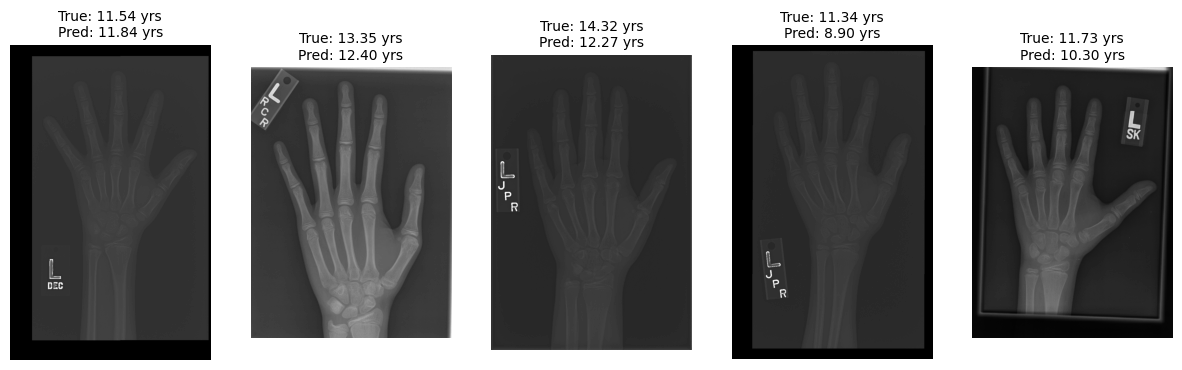

In [92]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import random
import os
import pandas as pd

# פונקציה להערכת מספר תמונות
def show_multiple_predictions(model, csv_path, image_folder, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # טעינת פרמטרי הנורמליזציה
    mean_age, std_age = np.load("CNN_Normalization_Params.npy")
    
    # טעינת הנתונים
    data = pd.read_csv(csv_path)
    data['image_id'] = data['Case ID'].astype(str) + '.png'
    data['boneage_years'] = data['Ground truth bone age (months)'] / 12  # המרה לשנים

    # בחירת דוגמאות אקראיות
    sample_rows = data.sample(num_samples)

    # הגדרת הטרנספורמציות
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for i, (_, row) in enumerate(sample_rows.iterrows()):
        image_path = os.path.join(image_folder, row['image_id'])
        true_age = row['boneage_years']

        # טעינת תמונה
        image = Image.open(image_path)
        image_transformed = transform(image).unsqueeze(0).to(device)  # הוספת ממד batch
        
        # ביצוע תחזית
        model.eval()
        with torch.no_grad():
            predicted_age = model(image_transformed).item()
            predicted_age = (predicted_age * std_age) + mean_age  # ביטול נורמליזציה
        
        # הצגת תמונה
        axes[i].imshow(image, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"True: {true_age:.2f} yrs\nPred: {predicted_age:.2f} yrs", fontsize=10)

    plt.show()

# טעינת המודל
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BoneAgeCNN().to(device)
model.load_state_dict(torch.load("CNN_Model.pth", map_location=device))

# קריאה לפונקציה עם 10 תמונות לדוגמה
show_multiple_predictions(model, "./Data/TestSet/lables.csv", "./Data/TestSet/Images/")
